# ICU Mortality Risk

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

In [5]:
# Load the available CSV file
csv_file_path = 'mimic_iv_data/mimic_iv_classification_regression_tasks.csv'
try:
    data_df = pd.read_csv(csv_file_path)
    print("\n--- Loaded Data (first 5 rows) ---")
    print(data_df.head())
except FileNotFoundError as e:
    print(f"Error: {e}")

# Data Exploration
def explore_data(df, name):
    print(f"\n--- {name} Data Info ---")
    print(df.info())  # Get information about data types and missing values
    print(f"\n--- Summary Statistics for {name} Data ---")
    print(df.describe(include='all'))  # Get summary statistics, including categorical data
    print(f"\n--- Missing Values in {name} Data ---")
    print(df.isnull().sum())  # Count missing values for each column

if 'data_df' in locals():
    explore_data(data_df, 'MIMIC-IV Classification and Regression Tasks')


--- Loaded Data (first 5 rows) ---
   subject_id   stay_id               intime              outtime  Age gender  \
0    10000032  39553978  2180-07-23 14:00:00  2180-07-23 23:50:47   52      F   
1    10000980  39765666  2189-06-27 08:42:00  2189-06-27 20:38:27   73      F   
2    10001217  37067082  2157-11-20 19:18:02  2157-11-21 22:08:00   55      F   
3    10001217  34592300  2157-12-19 15:42:24  2157-12-20 14:27:41   55      F   
4    10001725  31205490  2110-04-11 15:52:22  2110-04-12 23:59:56   46      F   

                ethnicity insurance  label                  dod   hadm_id  
0                   WHITE  Medicaid      0  2180-09-09 00:00:00  29079034  
1  BLACK/AFRICAN AMERICAN  Medicare      0  2193-08-26 00:00:00  26913865  
2                   WHITE     Other      0                    0  24597018  
3                   WHITE     Other      0                    0  27703517  
4                   WHITE     Other      0                    0  25563031  

--- MIMIC-IV Classif

In [9]:
# Data Cleaning and Feature Engineering

# Step 1: Convert date columns to datetime type
data_df['intime'] = pd.to_datetime(data_df['intime'], errors='coerce')
data_df['outtime'] = pd.to_datetime(data_df['outtime'], errors='coerce')
data_df['dod'] = pd.to_datetime(data_df['dod'], errors='coerce')

# Step 2: Feature Engineering
# Calculate length of stay (in days)
data_df['length_of_stay'] = (data_df['outtime'] - data_df['intime']).dt.total_seconds() / (60 * 60 * 24)

# Create a binary column to indicate whether the patient is deceased
data_df['is_deceased'] = data_df['dod'].notna().astype(int)

# Step 3: Define Categorical and Numerical Features
categorical_features = ['gender', 'ethnicity', 'insurance']
numerical_features = ['Age', 'length_of_stay']

# Step 4: Preprocessing Pipeline for Features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Step 5: Splitting Features and Target
# Target is 'label', which represents mortality (0: survived, 1: deceased)
X = data_df.drop(columns=['subject_id', 'stay_id', 'intime', 'outtime', 'dod', 'label'])
y = data_df['label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Step 6: Apply Preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Step 7: Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Original Training Set Class Distribution: {np.bincount(y_train)}")
print(f"Resampled Training Set Class Distribution: {np.bincount(y_train_resampled)}")

Original Training Set Class Distribution: [57408  4146]
Resampled Training Set Class Distribution: [57408 57408]


In [18]:
# Define Models for Training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Function to Train and Evaluate Models
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, prefix=""):
    results = {}
    for model_name, model in models.items():
        print(f"\n--- Training {model_name} {prefix} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"\nAccuracy for {model_name} {prefix}: {accuracy:.4f}")
        print(f"AUC-ROC for {model_name} {prefix}: {roc_auc:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
        results[model_name] = {"model": model, "accuracy": accuracy, "roc_auc": roc_auc}
    return results

# Train and Evaluate Models on Original Data
model_results = train_and_evaluate_models(models, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Train and Evaluate Models on SMOTE-Resampled Data
smote_results = train_and_evaluate_models(models, X_train_resampled, y_train_resampled, X_test_preprocessed, y_test, "After SMOTE")

# Hyperparameter Tuning for XGBoost with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("\n--- Starting Grid Search for Hyperparameter Tuning ---")
grid_search.fit(X_train_resampled, y_train_resampled)

best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest Parameters for XGBoost:", best_params)

y_pred_best = best_xgb.predict(X_test_preprocessed)
y_pred_proba_best = best_xgb.predict_proba(X_test_preprocessed)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print("\nAccuracy for Best XGBoost Model: {:.4f}".format(accuracy_best))
print("AUC-ROC for Best XGBoost Model: {:.4f}".format(roc_auc_best))
print("\nClassification Report for Best XGBoost Model:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix for Best XGBoost Model:\n", confusion_matrix(y_test, y_pred_best))


--- Training Logistic Regression  ---

Accuracy for Logistic Regression : 0.9342
AUC-ROC for Logistic Regression : 0.6997

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     14379
           1       0.45      0.01      0.03      1010

    accuracy                           0.93     15389
   macro avg       0.69      0.51      0.50     15389
weighted avg       0.90      0.93      0.90     15389


Confusion Matrix:
 [[14362    17]
 [  996    14]]

--- Training Random Forest  ---

Accuracy for Random Forest : 0.9134
AUC-ROC for Random Forest : 0.6197

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     14379
           1       0.13      0.06      0.08      1010

    accuracy                           0.91     15389
   macro avg       0.54      0.52      0.52     15389
weighted avg       0.88      0.91      0.90     15389


Confusion Matrix

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy for XGBoost : 0.9339
AUC-ROC for XGBoost : 0.6936

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97     14379
           1       0.18      0.00      0.00      1010

    accuracy                           0.93     15389
   macro avg       0.56      0.50      0.48     15389
weighted avg       0.89      0.93      0.90     15389


Confusion Matrix:
 [[14370     9]
 [ 1008     2]]

--- Training Logistic Regression After SMOTE ---

Accuracy for Logistic Regression After SMOTE: 0.6911
AUC-ROC for Logistic Regression After SMOTE: 0.7045

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     14379
           1       0.12      0.62      0.21      1010

    accuracy                           0.69     15389
   macro avg       0.54      0.66      0.51     15389
weighted avg       0.91      0.69      0.77     15389


Confusion Matrix:
 [[10011  

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy for XGBoost After SMOTE: 0.8086
AUC-ROC for XGBoost After SMOTE: 0.6659

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89     14379
           1       0.14      0.36      0.20      1010

    accuracy                           0.81     15389
   macro avg       0.54      0.60      0.54     15389
weighted avg       0.90      0.81      0.85     15389


Confusion Matrix:
 [[12079  2300]
 [  645   365]]

--- Starting Grid Search for Hyperparameter Tuning ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}

Accuracy for Best XGBoost Model: 0.8182
AUC-ROC for Best XGBoost Model: 0.6563

Classification Report for Best XGBoost Model:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90     14379
           1       0.13      0.31      0.18      1010

    accuracy                           0.82     15389
   macro avg       0.54      0.58      0.54     15389
weighted avg       0.89      0.82      0.85     15389


Confusion Matrix for Best XGBoost Model:
 [[12282  2097]
 [  701   309]]


In [19]:
# Evaluate Model at Different Thresholds
def evaluate_threshold(model, X_test, y_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    print(f"\n--- Evaluation Metrics at Threshold {threshold:.2f} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", confusion)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    evaluate_threshold(best_xgb, X_test_preprocessed, y_test, threshold)

# Final Evaluation at Selected Threshold
selected_threshold = 0.40
y_pred_threshold_40 = (best_xgb.predict_proba(X_test_preprocessed)[:, 1] >= selected_threshold).astype(int)
print("\n--- Final Evaluation Metrics at Selected Threshold (0.40) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_threshold_40))
print("AUC-ROC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test_preprocessed)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred_threshold_40))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold_40))


--- Evaluation Metrics at Threshold 0.30 ---
Accuracy: 0.5842
AUC-ROC: 0.6563

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72     14379
           1       0.10      0.63      0.17      1010

    accuracy                           0.58     15389
   macro avg       0.53      0.61      0.44     15389
weighted avg       0.90      0.58      0.69     15389


Confusion Matrix:
 [[8353 6026]
 [ 372  638]]

--- Evaluation Metrics at Threshold 0.40 ---
Accuracy: 0.7197
AUC-ROC: 0.6563

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.74      0.83     14379
           1       0.11      0.47      0.18      1010

    accuracy                           0.72     15389
   macro avg       0.53      0.61      0.51     15389
weighted avg       0.90      0.72      0.79     15389


Confusion Matrix:
 [[10596  3783]
 [  531   479]]

--- Evaluation Metrics at Threshold 0.5

100%|===================| 15372/15389 [00:43<00:00]        

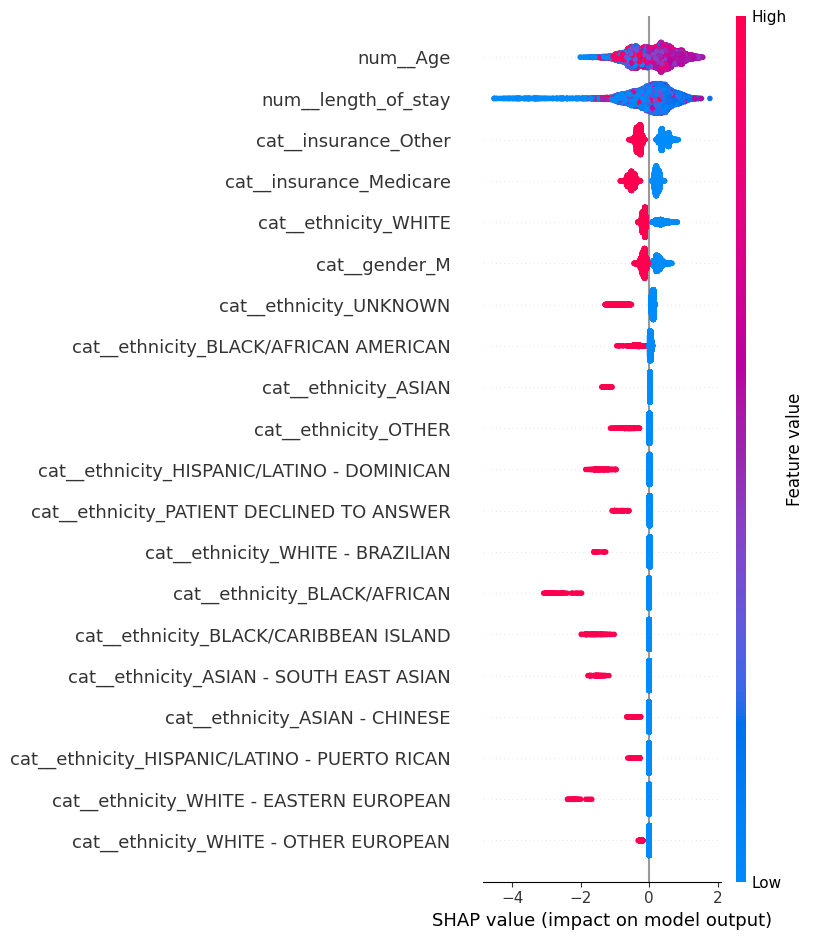

<Figure size 640x480 with 0 Axes>

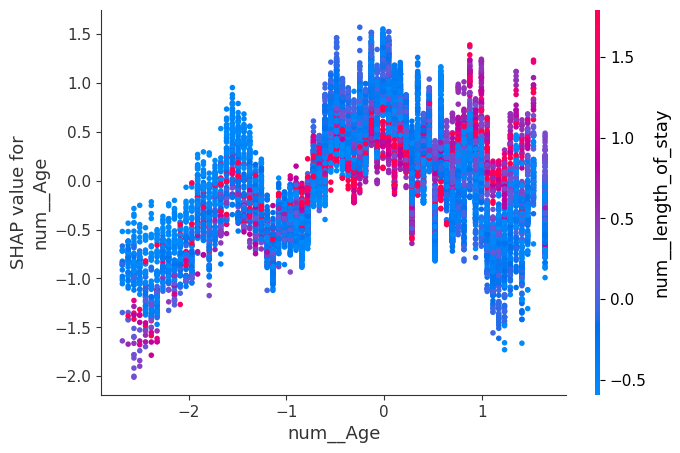

In [28]:
import shap
import matplotlib.pyplot as plt

# SHAP Interpretation for XGBoost Model
shap.initjs()

# Convert X_test_preprocessed to dense format if it's a sparse matrix
X_test_dense = X_test_preprocessed.toarray() if hasattr(X_test_preprocessed, "toarray") else X_test_preprocessed

# Create a SHAP explainer
explainer = shap.Explainer(best_xgb, X_test_dense)

# Calculate SHAP values
shap_values = explainer(X_test_dense)

# Extract feature names from preprocessor for use in plots
feature_names = preprocessor.get_feature_names_out()

# --- SHAP Summary Plot ---
plt.figure()
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)

# --- SHAP Dependence Plot ---
# Get the correct feature name for 'Age'
age_feature_name = [name for name in feature_names if 'Age' in name][0]

# Plot dependence for the 'Age' feature
plt.figure()
shap.dependence_plot(age_feature_name, shap_values.values, X_test_dense, feature_names=feature_names)

In [ ]:
# Evaluate SHAP Summary Plot: Use the SHAP summary plot to assess which features have the highest impact on the model predictions. Look for patterns such as:
# If Age is consistently a high-impact feature, it suggests older age significantly influences ICU mortality risk.
# Features like length_of_stay or insurance can provide insights into socioeconomic or healthcare factors affecting outcomes.

# Improve Model Based on Insights: Insights from SHAP can be used to:
# Remove Unimportant Features: Reduce noise by removing features that have a low impact.
# Engineer New Features: Create interaction features if two factors together appear significant.

In [44]:
# New Data

import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# Define the number of synthetic samples
n_samples = 10

# Generate a more varied synthetic dataset
# We'll use make_classification to generate numerical features for 'Age' and 'length_of_stay'
# and generate categorical values manually.

# Numerical features: generate varied age and length of stay
n_numerical = len(['Age', 'length_of_stay'])
X_synthetic_numerical, _ = make_classification(
    n_samples=n_samples,
    n_features=n_numerical,
    n_informative=n_numerical,
    n_redundant=0,
    random_state=42,
    shift=[50, 7],  # Shifting the mean of 'Age' to a realistic average age and 'length_of_stay' to 7 days
    scale=[15, 3]   # Adding variability in 'Age' and 'length_of_stay'
)

# Ensure numerical features are within reasonable bounds
X_synthetic_numerical = np.clip(X_synthetic_numerical, [18, 0.5], [91, 30])  # Age between 18 and 91, LOS between 0.5 and 30 days

# Generate synthetic categorical features
np.random.seed(42)
gender_options = ['M', 'F']
ethnicity_options = [
    'WHITE', 'BLACK/AFRICAN AMERICAN', 'ASIAN - CHINESE', 'HISPANIC OR LATINO', 'OTHER'
]
insurance_options = ['Medicare', 'Medicaid', 'Private', 'Other']

gender_synthetic = np.random.choice(gender_options, size=n_samples)
ethnicity_synthetic = np.random.choice(ethnicity_options, size=n_samples)
insurance_synthetic = np.random.choice(insurance_options, size=n_samples)

# Combine numerical and categorical features
synthetic_data = {
    'Age': X_synthetic_numerical[:, 0],
    'length_of_stay': X_synthetic_numerical[:, 1],
    'gender': gender_synthetic,
    'ethnicity': ethnicity_synthetic,
    'insurance': insurance_synthetic
}

# Create a DataFrame for the synthetic data
synthetic_data_df = pd.DataFrame(synthetic_data)

# Display the synthetic data to verify its diversity
print("\n--- New Synthetic Data (first 5 rows) ---")
print(synthetic_data_df.head())

# Step 2: Preprocess the New Data
# Convert categorical variables using the fitted preprocessor
X_synthetic_preprocessed = preprocessor.transform(synthetic_data_df)

# Step 3: Predict the mortality risk for synthetic data using the trained XGBoost model
predicted_probabilities = best_xgb.predict_proba(X_synthetic_preprocessed)[:, 1]
predicted_classes = (predicted_probabilities >= selected_threshold).astype(int)

# Display the predictions
print("\n--- Predicted Mortality Risk for New Synthetic Data ---")
print(predicted_classes)

# Optionally, display the predicted probabilities as well
print("\n--- Predicted Mortality Risk Probabilities for New Synthetic Data ---")
print(predicted_probabilities)


--- New Synthetic Data (first 5 rows) ---
         Age  length_of_stay gender           ethnicity insurance
0  24.205017            30.0      M     ASIAN - CHINESE     Other
1  18.000000            30.0      F     ASIAN - CHINESE     Other
2  18.000000            30.0      M     ASIAN - CHINESE  Medicare
3  18.838097            30.0      M               OTHER  Medicare
4  18.000000            30.0      M  HISPANIC OR LATINO     Other

--- Predicted Mortality Risk for New Synthetic Data ---
[0 0 0 0 0 0 0 1 0 0]

--- Predicted Mortality Risk Probabilities for New Synthetic Data ---
[0.19919878 0.06491542 0.21213286 0.03434963 0.12656136 0.04006183
 0.0301909  0.6604589  0.10452123 0.22592306]
